特征矩阵形状: (1312, 10000)

10-Fold CV 平均准确率: 0.5938

--- Test Set Classification Report ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.47      0.51      0.49        68
Frontotemporal Dementia       0.81      0.58      0.67        59
     Lewy Body Dementia       0.67      0.56      0.61        64
    Parkinson's Disease       0.56      0.62      0.59        68
      Vascular Dementia       0.61      0.73      0.67        70

               accuracy                           0.60       329
              macro avg       0.62      0.60      0.61       329
           weighted avg       0.62      0.60      0.60       329



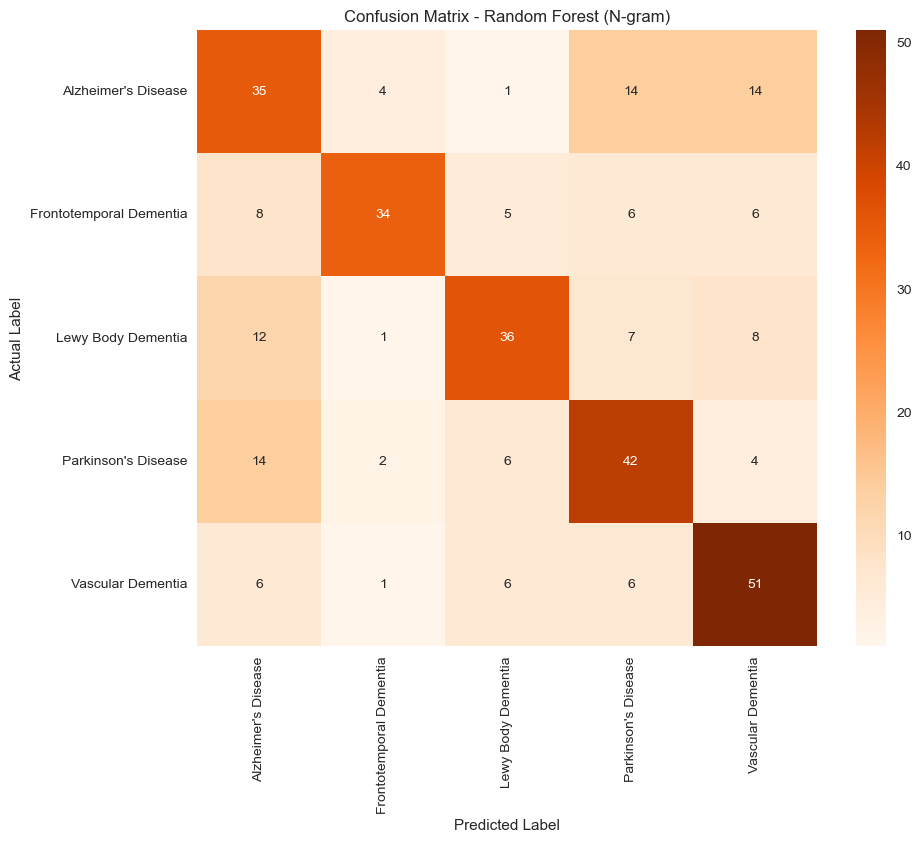

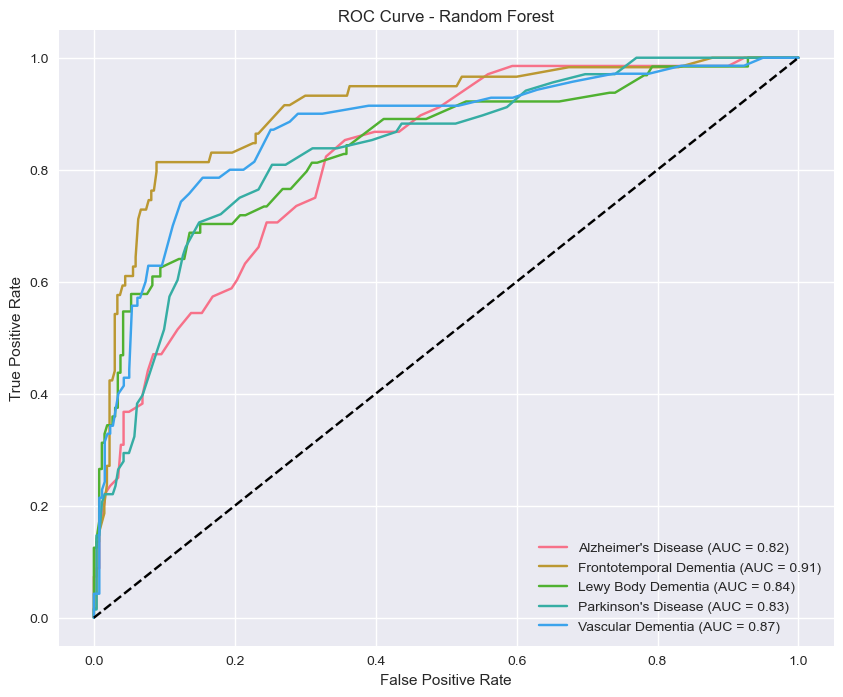

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14120\1977318197.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices], palette="viridis")


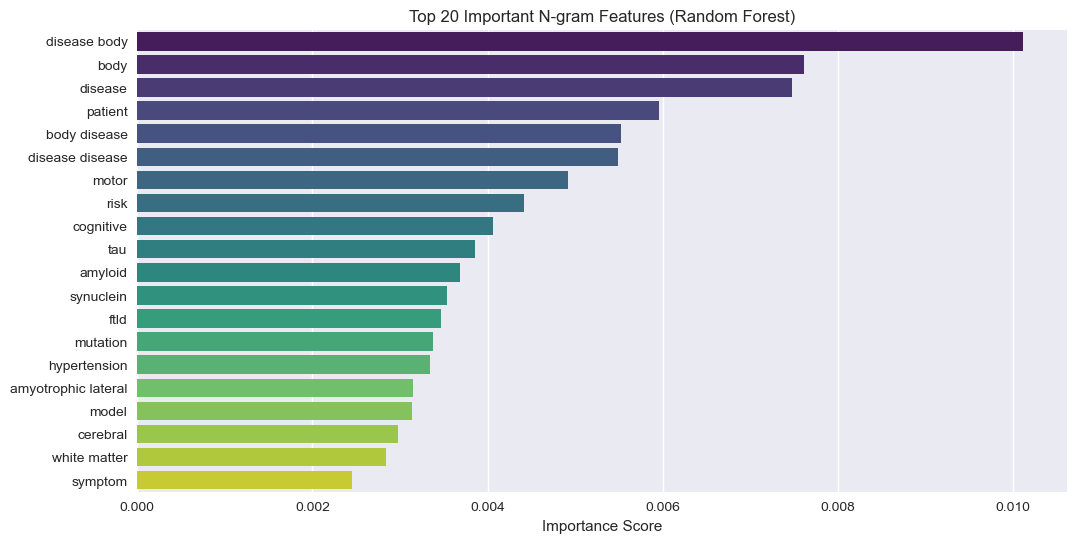

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# 设置绘图风格
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ==========================================
# 1. 数据准备
# ==========================================
df = pd.read_csv('../cleaned_data.csv')
# 确保文本无空值
df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

# 划分训练集和测试集
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label'], test_size=0.2, random_state=42, stratify=df['Label']
)

# ==========================================
# 2. 特征工程: N-gram (Unigram + Bigram)
# ==========================================
# 使用 CountVectorizer 提取 1-gram 和 2-gram 特征
# max_features 限制为 10000 个最常见特征，防止随机森林训练过慢
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)

X_train_vec = vectorizer.fit_transform(X_train_raw)
X_test_vec = vectorizer.transform(X_test_raw)

print(f"特征矩阵形状: {X_train_vec.shape}")

# ==========================================
# 3. 模型训练: Random Forest Classifier
# ==========================================
# n_estimators=100: 树的数量
# n_jobs=-1: 使用所有CPU核心加速
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 10折交叉验证
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_vec, y_train, cv=cv, scoring='accuracy')

print(f"\n10-Fold CV 平均准确率: {cv_scores.mean():.4f}")

# 在全量训练集上训练
rf_model.fit(X_train_vec, y_train)

# ==========================================
# 4. 评估与可视化
# ==========================================
y_pred = rf_model.predict(X_test_vec)
y_prob = rf_model.predict_proba(X_test_vec)

print("\n--- Test Set Classification Report ---")
print(classification_report(y_test, y_pred))

# [图表 1] 混淆矩阵 (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - Random Forest (N-gram)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# [图表 2] ROC 曲线
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
classes = lb.classes_

plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

# [图表 3] 特征重要性 (Feature Importance)
# 随机森林可以直接输出特征重要性
feature_names = vectorizer.get_feature_names_out()
importances = rf_model.feature_importances_
# 获取前20个最重要的特征
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices], palette="viridis")
plt.title("Top 20 Important N-gram Features (Random Forest)")
plt.xlabel("Importance Score")
plt.show()